# Importing Packages

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm.notebook import tqdm

import warnings
warnings.simplefilter("ignore")

import tensorflow as tf
from keras import models, layers, regularizers, optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.applications.vgg16 import VGG16


# Baseline Model:  Densely Connected Network

In [2]:
train = pd.read_csv('../data/train.csv', index_col=0)
train.head()

,file,target
0,ISIC_1569119,1
1,ISIC_7536704,1
2,ISIC_3696488,1
3,ISIC_3343475,1
4,ISIC_7785723,1


In [3]:
val = pd.read_csv('../data/val.csv', index_col=0)
val.head()

,file,target
0,ISIC_6767569,1
1,ISIC_7312977,1
2,ISIC_1785627,1
3,ISIC_8066110,1
4,ISIC_8838753,1


In [5]:
test = pd.read_csv('../data/test_df.csv', index_col=0)
test.head()

,file,age,site,lesion_id,gender,target,jpg
0,ISIC_0000000,55.0,anterior torso,NaN,female,0,ISIC_0000000.jpg
1,ISIC_0000001,30.0,anterior torso,NaN,female,0,ISIC_0000001.jpg
2,ISIC_0000002,60.0,upper extremity,NaN,female,1,ISIC_0000002.jpg
3,ISIC_0000003,30.0,upper extremity,NaN,male,0,ISIC_0000003.jpg
4,ISIC_0000004,80.0,posterior torso,NaN,male,1,ISIC_0000004.jpg


In [4]:
data_fldr = "../data"
train_fldr = "../split/train"
val_fldr = "../split/val"

In [11]:
test.head()

,file,age,site,lesion_id,gender,target,jpg
0,ISIC_0000000,55.0,anterior torso,NaN,female,0,ISIC_0000000.jpg
1,ISIC_0000001,30.0,anterior torso,NaN,female,0,ISIC_0000001.jpg
2,ISIC_0000002,60.0,upper extremity,NaN,female,1,ISIC_0000002.jpg
3,ISIC_0000003,30.0,upper extremity,NaN,male,0,ISIC_0000003.jpg
4,ISIC_0000004,80.0,posterior torso,NaN,male,1,ISIC_0000004.jpg


In [27]:
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_fldr, 
        target_size = (256, 256),
        batch_size = 32)

train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_fldr, 
        target_size = (256, 256),
        batch_size = 32)

Found 6626 images belonging to 2 classes.
Found 26500 images belonging to 2 classes.


In [28]:
train_images, train_labels = next(train_generator)
val_images, val_labels = next(val_generator)

In [29]:
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 32
Number of validation samples: 32
train_images shape: (32, 256, 256, 3)
train_labels shape: (32, 2)
val_images shape: (32, 256, 256, 3)
val_labels shape: (32, 2)


In [30]:
train_img = train_images.reshape(train_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(val_img.shape)

(32, 196608)
(32, 196608)


In [11]:
train_y = np.reshape(train_labels[:,0], (32,1))
val_y = np.reshape(val_labels[:,0], (32,1))

In [31]:
model = models.Sequential()
model.add(layers.Dense(20, activation='relu', input_shape=(196608,))) # 2 hidden layers
model.add(layers.Dense(7, activation='relu'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [37]:
model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy', tf.metrics.Precision(), tf.metrics.Recall(), tf.metrics.AUC(), tf.metrics.AUC(curve='PR')])

history = model.fit(train_img,
                     train_y,
                     epochs=50,
                     batch_size=32,
                     validation_data=(val_img, val_y))

Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 0.6696 - accuracy: 1.0000 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - auc_5: 0.0000e+00 - auc_6: 0.0000e+00 - val_loss: 0.6706 - val_accuracy: 0.9688 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_auc_5: 0.5000 - val_auc_6: 0.0312
Epoch 2/50
1/1 [==============================] - 0s 84ms/step - loss: 0.6691 - accuracy: 1.0000 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - auc_5: 0.0000e+00 - auc_6: 0.0000e+00 - val_loss: 0.6702 - val_accuracy: 0.9688 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_auc_5: 0.5000 - val_auc_6: 0.0312
Epoch 3/50
1/1 [==============================] - 0s 82ms/step - loss: 0.6686 - accuracy: 1.0000 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - auc_5: 0.0000e+00 - auc_6: 0.0000e+00 - val_loss: 0.6697 - val_accuracy: 0.9688 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_auc_5: 0.5000 - val_auc_6: 0.0312
Epoch 4/50
1/1 [===========

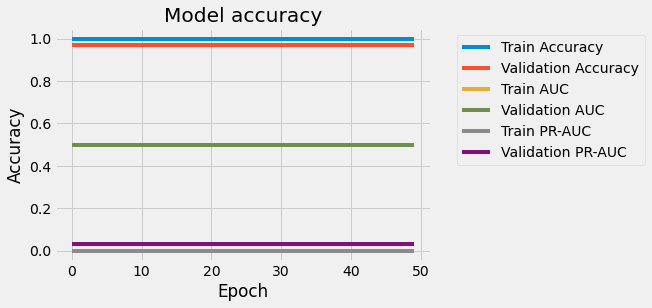

In [41]:
plt.style.use('fivethirtyeight')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['auc_5'])
plt.plot(history.history['val_auc_5'])
plt.plot(history.history['auc_6'])
plt.plot(history.history['val_auc_6'])
plt.plot
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Validation Accuracy', 'Train AUC', 'Validation AUC', 'Train PR-AUC', 'Validation PR-AUC'], loc='best', bbox_to_anchor=(1.05, 1))
plt.show()

In [42]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 20)                3932180   
_________________________________________________________________
dense_7 (Dense)              (None, 7)                 147       
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 40        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 6         
Total params: 3,932,373
Trainable params: 3,932,373
Non-trainable params: 0
_________________________________________________________________


In [23]:
results_train = model.evaluate(train_img, train_y)

1/1 [==============================] - 0s 26ms/step - loss: 7.6074e-06 - accuracy: 1.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc_1: 0.0000e+00 - auc_2: 0.0000e+00


In [20]:
results_test = model.evaluate(test_img, test_y)

1/1 [==============================] - 0s 23ms/step - loss: 1.1338 - accuracy: 0.7812


In [24]:
results_train

[7.607447969348868e-06, 1.0, 0.0, 0.0, 0.0, 0.0]

In [22]:
results_test

[1.1337727308273315, 0.78125]

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                3932180   
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 147       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 40        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 3,932,373
Trainable params: 3,932,373
Non-trainable params: 0
_________________________________________________________________


# Build a CNN

In [46]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (4, 4), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics = ['accuracy', tf.metrics.Precision(), tf.metrics.Recall(), tf.metrics.AUC(), tf.metrics.AUC(curve='PR')])

In [47]:
history = model.fit(train_images,
                    train_y,
                    epochs=30,
                    batch_size=32,
                    validation_data=(val_images, val_y))

Epoch 1/30
1/1 [==============================] - 8s 8s/step - loss: 0.6981 - accuracy: 0.0938 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - auc_7: 0.0000e+00 - auc_8: 0.0000e+00 - val_loss: 1.5682 - val_accuracy: 0.9688 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_auc_7: 0.5000 - val_auc_8: 0.0312
Epoch 2/30
1/1 [==============================] - 2s 2s/step - loss: 1.4640e-05 - accuracy: 1.0000 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - auc_7: 0.0000e+00 - auc_8: 0.0000e+00 - val_loss: 3.1254 - val_accuracy: 0.9688 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_auc_7: 0.5000 - val_auc_8: 0.0312
Epoch 3/30
1/1 [==============================] - 2s 2s/step - loss: 5.7599e-09 - accuracy: 1.0000 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - auc_7: 0.0000e+00 - auc_8: 0.0000e+00 - val_loss: 4.7893 - val_accuracy: 0.9688 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_auc_7: 0.5000 - val_auc_8: 0.0312
Epoch 4/30
1/1 [=======

In [48]:
results_train = model.evaluate(train_images, train_y)

1/1 [==============================] - 0s 361ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - auc_7: 0.0000e+00 - auc_8: 0.0000e+00


In [40]:
results_test = model.evaluate(test_images, test_y)

1/1 [==============================] - 1s 541ms/step - loss: 0.8336 - acc: 0.7500


In [49]:
results_train

[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]

In [42]:
results_test

[0.8335974216461182, 0.75]

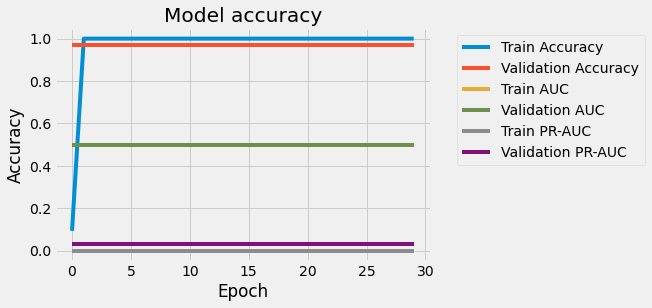

In [50]:
plt.style.use('fivethirtyeight')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['auc_7'])
plt.plot(history.history['val_auc_7'])
plt.plot(history.history['auc_8'])
plt.plot(history.history['val_auc_8'])
plt.plot
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Validation Accuracy', 'Train AUC', 'Validation AUC', 'Train PR-AUC', 'Validation PR-AUC'], loc='best', bbox_to_anchor=(1.05, 1))
plt.show()

In [60]:
vgg16 = VGG16(include_top=False, 
              weights='imagenet', 
              input_shape=(256, 256, 3))

for layer in vgg16.layers:
    layer.trainable = False

input_ = vgg16.input
output_ = vgg16(input_)
last_layer = Flatten(name='flatten')(output_)
last_layer = Dense(1, activation='sigmoid')(last_layer)
model = Model(inputs=input_, outputs=last_layer)

model.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy',
              metrics = ['accuracy', tf.metrics.Precision(), tf.metrics.Recall(), tf.metrics.AUC(), tf.metrics.AUC(curve='PR')])

train_data_gen = ImageDataGenerator(rescale = 1./255)
val_data_gen = ImageDataGenerator(rescale = 1./255)

train_set = train_data_gen.flow_from_directory(train_fldr,
                                               target_size = (256, 256),
                                               batch_size = 32,
                                               class_mode = 'binary')
val_set = val_data_gen.flow_from_directory(val_fldr,
                                           target_size = (256, 256),
                                           batch_size = 32,
                                           class_mode = 'binary')


# score = model.evaluate_generator(test_set, len(test_set))

# for idx, metric in enumerate(model.metrics_names):
    # print("{}: {}".format(metric, score[idx]))                    

Found 26500 images belonging to 2 classes.
Found 6626 images belonging to 2 classes.


In [61]:
model.fit_generator(train_set,
                    steps_per_epoch = 20, 
                    epochs = 10, 
                    verbose = 1)

Epoch 1/10
20/20 [==============================] - 223s 11s/step - loss: 0.2959 - accuracy: 0.8191 - precision_7: 0.9445 - recall_7: 0.8257 - auc_15: 0.3015 - auc_16: 0.9908
Epoch 2/10
20/20 [==============================] - 202s 10s/step - loss: 0.4739 - accuracy: 0.9720 - precision_7: 0.9720 - recall_7: 1.0000 - auc_15: 0.5000 - auc_16: 0.9720
Epoch 3/10
12/20 [=================>............] - ETA: 1:35 - loss: 0.1809 - accuracy: 0.9736 - precision_7: 0.9736 - recall_7: 1.0000 - auc_15: 0.5480 - auc_16: 0.9768

UnknownError:  OSError: image file is truncated (5 bytes not processed)
Traceback (most recent call last):

  File "/Users/examsherpa/opt/anaconda3/envs/nn-env/lib/python3.6/site-packages/tensorflow/python/ops/script_ops.py", line 249, in __call__
    ret = func(*args)

  File "/Users/examsherpa/opt/anaconda3/envs/nn-env/lib/python3.6/site-packages/tensorflow/python/autograph/impl/api.py", line 620, in wrapper
    return func(*args, **kwargs)

  File "/Users/examsherpa/opt/anaconda3/envs/nn-env/lib/python3.6/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 891, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/Users/examsherpa/opt/anaconda3/envs/nn-env/lib/python3.6/site-packages/tensorflow/python/keras/engine/data_adapter.py", line 807, in wrapped_generator
    for data in generator_fn():

  File "/Users/examsherpa/opt/anaconda3/envs/nn-env/lib/python3.6/site-packages/tensorflow/python/keras/engine/data_adapter.py", line 933, in generator_fn
    yield x[i]

  File "/Users/examsherpa/opt/anaconda3/envs/nn-env/lib/python3.6/site-packages/keras_preprocessing/image/iterator.py", line 65, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)

  File "/Users/examsherpa/opt/anaconda3/envs/nn-env/lib/python3.6/site-packages/keras_preprocessing/image/iterator.py", line 230, in _get_batches_of_transformed_samples
    interpolation=self.interpolation)

  File "/Users/examsherpa/opt/anaconda3/envs/nn-env/lib/python3.6/site-packages/keras_preprocessing/image/utils.py", line 138, in load_img
    img = img.resize(width_height_tuple, resample)

  File "/Users/examsherpa/opt/anaconda3/envs/nn-env/lib/python3.6/site-packages/PIL/Image.py", line 1916, in resize
    self.load()

  File "/Users/examsherpa/opt/anaconda3/envs/nn-env/lib/python3.6/site-packages/PIL/ImageFile.py", line 260, in load
    "image file is truncated "

OSError: image file is truncated (5 bytes not processed)


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_33783]

Function call stack:
train_function
